# GAN-based Daily-Shape Clustering

**Dataset:** UCI ElectricityLoadDiagrams2011–2014 (Portugal)

This notebook trains an InfoGAN-style model to discover clusters of daily electricity usage shapes.
Outputs: cluster labels, metrics, and a t-SNE plot.

**Steps**
1. Load & preprocess data into 24-dim daily profiles
2. Train InfoGAN (Generator, Discriminator, Q-network)
3. Infer cluster labels for real samples using the Q-network
4. Evaluate with Silhouette + Davies–Bouldin; visualize with t-SNE

In [28]:
!python -V
import sys, torch, numpy, sklearn, pandas, matplotlib
print('torch', torch.__version__)

Python 3.11.9
torch 2.8.0+cpu


In [29]:
import os, json, math, numpy as np, torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from nb_utils import load_eld_daily, evaluate_clustering, plot_tsne, save_outputs, seed_everything
seed_everything(42)

## 1) Configure paths and hyperparameters

In [30]:
DATA_PATH = '../data/LD2011_2014.txt'  # <- change if needed
OUT_DIR = '../results_gan'
N_CLUSTERS = 5
BATCH_SIZE = 256
EPOCHS = 300
LR = 2e-4
Z_DIM = 16
SAMPLE_SIZE = 2000  # set None to use all
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## 2) Load & preprocess data

In [31]:
X, meta = load_eld_daily(DATA_PATH, normalize='zscore', sample_size=SAMPLE_SIZE)
print(X.shape, meta['n_features'])
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

(2000, 24) 24


## 3) Define InfoGAN (G, D with shared features, and Q-network)

In [32]:

class Generator(nn.Module):
    def __init__(self, z_dim=16, n_clusters=5, out_dim=24):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + n_clusters, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self, z, c_onehot):
        x = torch.cat([z, c_onehot], dim=1)
        return self.net(x)

class DiscShared(nn.Module):
    def __init__(self, in_dim=24):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.LeakyReLU(0.2),
            nn.Linear(128, 128), nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, in_dim=24):
        super().__init__()
        self.fc = nn.Linear(128, 1)
    def forward(self, h):
        return torch.sigmoid(self.fc(h))

class QNet(nn.Module):
    def __init__(self, n_clusters=5):
        super().__init__()
        self.q = nn.Linear(128, n_clusters)
    def forward(self, h):
        return self.q(h)

G = Generator(Z_DIM, N_CLUSTERS).to(DEVICE)
Shared = DiscShared().to(DEVICE)
D = Discriminator().to(DEVICE)
Q = QNet(N_CLUSTERS).to(DEVICE)

optD = optim.Adam(list(Shared.parameters()) + list(D.parameters()), lr=LR, betas=(0.5, 0.999))
optGQ = optim.Adam(list(G.parameters()) + list(Q.parameters()), lr=LR, betas=(0.5, 0.999))

bce = nn.BCELoss()
ce = nn.CrossEntropyLoss()
    

## 4) Training loop

In [33]:

def sample_c(batch, n_clusters):
    idx = torch.randint(low=0, high=n_clusters, size=(batch,), device=DEVICE)
    onehot = torch.zeros(batch, n_clusters, device=DEVICE)
    onehot[torch.arange(batch), idx] = 1.0
    return idx, onehot

for epoch in range(1, EPOCHS+1):
    lossD_acc, lossG_acc, lossInfo_acc = 0., 0., 0.
    for (xb,) in loader:
        xb = xb.to(DEVICE)

        # === Train Discriminator ===
        Shared.train(); D.train(); Q.train(); G.train()
        optD.zero_grad()
        h_real = Shared(xb)
        pred_real = D(h_real)
        y_real = torch.ones_like(pred_real)
        loss_real = bce(pred_real, y_real)

        z = torch.randn(xb.size(0), Z_DIM, device=DEVICE)
        c_idx, c_1h = sample_c(xb.size(0), N_CLUSTERS)
        x_fake = G(z, c_1h).detach()
        h_fake = Shared(x_fake)
        pred_fake = D(h_fake)
        y_fake = torch.zeros_like(pred_fake)
        loss_fake = bce(pred_fake, y_fake)

        lossD = (loss_real + loss_fake) * 0.5
        lossD.backward()
        optD.step()

        # === Train Generator + Q ===
        optGQ.zero_grad()
        z = torch.randn(xb.size(0), Z_DIM, device=DEVICE)
        c_idx, c_1h = sample_c(xb.size(0), N_CLUSTERS)
        x_fake = G(z, c_1h)
        h_fake = Shared(x_fake)
        pred_fake = D(h_fake)
        lossG = bce(pred_fake, torch.ones_like(pred_fake))
        logits_c = Q(h_fake)
        lossInfo = ce(logits_c, c_idx)
        (lossG + 1.0*lossInfo).backward()
        optGQ.step()

        lossD_acc += lossD.item()
        lossG_acc += lossG.item()
        lossInfo_acc += lossInfo.item()

    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{EPOCHS}  Loss_D: {lossD_acc/len(loader):.4f}  Loss_G: {lossG_acc/len(loader):.4f}  Loss_Info: {lossInfo_acc/len(loader):.4f}")
    

Epoch 1/300  Loss_D: 0.6511  Loss_G: 0.6740  Loss_Info: 1.6078
Epoch 50/300  Loss_D: 0.6719  Loss_G: 0.8072  Loss_Info: 1.4914
Epoch 50/300  Loss_D: 0.6719  Loss_G: 0.8072  Loss_Info: 1.4914
Epoch 100/300  Loss_D: 0.5600  Loss_G: 0.8864  Loss_Info: 0.5497
Epoch 100/300  Loss_D: 0.5600  Loss_G: 0.8864  Loss_Info: 0.5497
Epoch 150/300  Loss_D: 0.6223  Loss_G: 0.7844  Loss_Info: 0.4405
Epoch 150/300  Loss_D: 0.6223  Loss_G: 0.7844  Loss_Info: 0.4405
Epoch 200/300  Loss_D: 0.6132  Loss_G: 0.8527  Loss_Info: 0.2932
Epoch 200/300  Loss_D: 0.6132  Loss_G: 0.8527  Loss_Info: 0.2932
Epoch 250/300  Loss_D: 0.6224  Loss_G: 0.7870  Loss_Info: 0.1789
Epoch 250/300  Loss_D: 0.6224  Loss_G: 0.7870  Loss_Info: 0.1789
Epoch 300/300  Loss_D: 0.7079  Loss_G: 0.7075  Loss_Info: 0.1214
Epoch 300/300  Loss_D: 0.7079  Loss_G: 0.7075  Loss_Info: 0.1214


## 5) Infer cluster labels for REAL data using Q-network

In [34]:

G.eval(); Shared.eval(); Q.eval()
with torch.no_grad():
    X_t = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    h = Shared(X_t)
    logits = Q(h)
    labels = logits.argmax(dim=1).cpu().numpy()
print("Labels shape:", labels.shape, "Num clusters found:", len(set(labels)))
    

Labels shape: (2000,) Num clusters found: 5


## 6) Evaluate & visualize

{'silhouette': -0.011552253738045692, 'davies_bouldin': 2.6675071931160756}


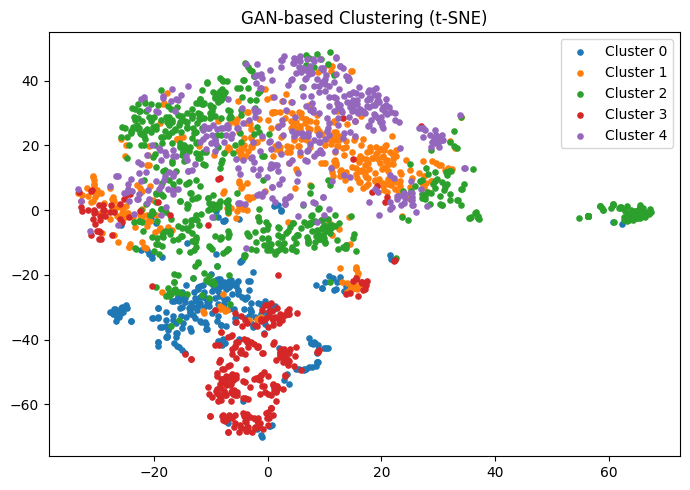

Saved to ../results_gan


In [35]:
metrics = evaluate_clustering(X, labels)
print(metrics)
plot_tsne(X, labels, title='GAN-based Clustering (t-SNE)', savepath=os.path.join(OUT_DIR, 'tsne_gan.png'))
save_outputs(OUT_DIR, 'gan', labels, None, metrics)
print('Saved to', OUT_DIR)

## Task: Quick EDA — inspect a few daily profiles

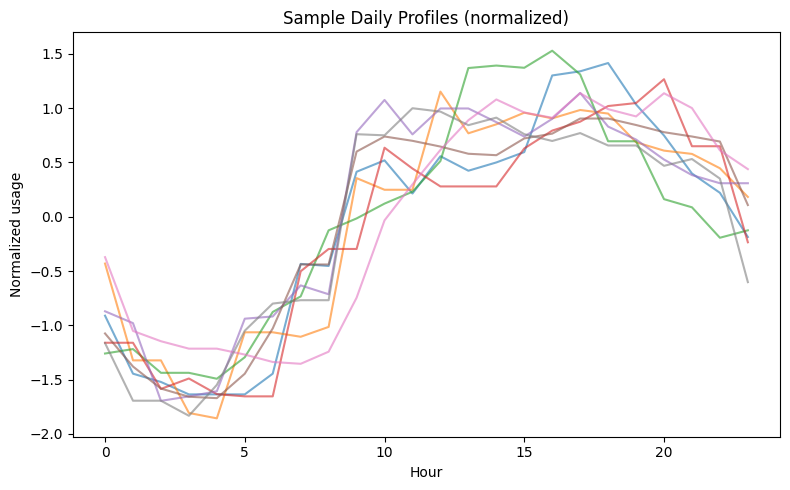

In [36]:
import numpy as np, matplotlib.pyplot as plt
idx = np.random.choice(len(X), size=min(8, len(X)), replace=False)
hours = np.arange(24)
plt.figure(figsize=(8,5))
for i in idx:
    plt.plot(hours, X[i], alpha=0.6)
plt.title('Sample Daily Profiles (normalized)')
plt.xlabel('Hour'); plt.ylabel('Normalized usage'); plt.tight_layout(); plt.show()

## Task: Cluster diagnostics — sizes, silhouettes, and mean profiles

Cluster sizes: [267 402 600 314 417]


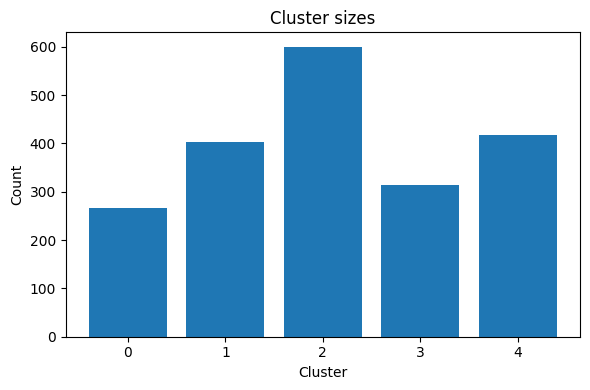

silhouette             
              mean median count
cluster                        
0            0.160  0.173   267
1            0.090  0.116   402
2           -0.248 -0.259   600
3            0.128  0.147   314
4            0.016  0.022   417

In [37]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
labels = np.asarray(labels)
K = len(np.unique(labels))
sizes = np.bincount(labels, minlength=K)
print('Cluster sizes:', sizes)

# Bar chart of cluster sizes
plt.figure(figsize=(6,4))
plt.bar(np.arange(K), sizes)
plt.xlabel('Cluster'); plt.ylabel('Count'); plt.title('Cluster sizes')
plt.tight_layout(); plt.show()

# Per-sample silhouettes, then per-cluster summary
sil_samples = silhouette_samples(X, labels)
df = pd.DataFrame({'cluster': labels, 'silhouette': sil_samples})
summary = df.groupby('cluster').agg(['mean','median','count']).round(3)
summary

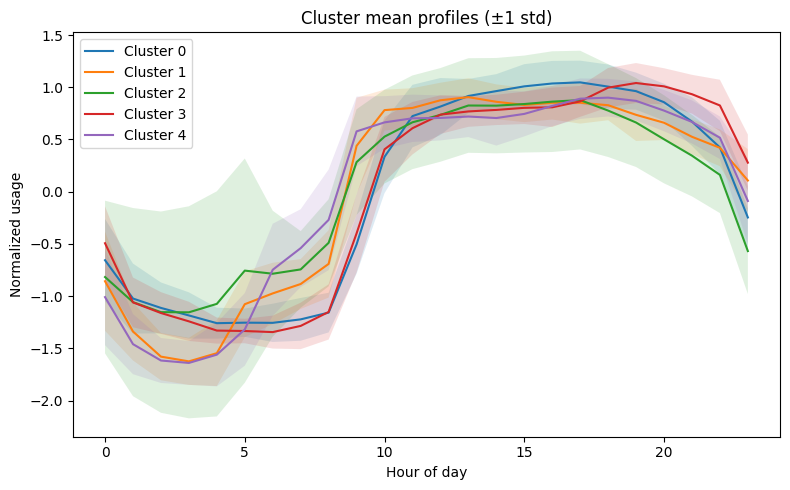

In [38]:
# Mean ± std 24h profile per cluster
hours = np.arange(24)
plt.figure(figsize=(8,5))
for k in range(K):
    Xk = X[labels==k]
    m = Xk.mean(axis=0)
    s = Xk.std(axis=0)
    plt.plot(hours, m, label=f'Cluster {k}')
    plt.fill_between(hours, m-s, m+s, alpha=0.15)
plt.xlabel('Hour of day'); plt.ylabel('Normalized usage')
plt.title('Cluster mean profiles (±1 std)')
plt.legend(); plt.tight_layout(); plt.show()

In [39]:
# Save a compact CSV summary (for report)
import os, json
summary_csv = summary.reset_index()
out_dir = OUT_DIR if 'OUT_DIR' in globals() else '.'
os.makedirs(out_dir, exist_ok=True)
summary_csv.to_csv(os.path.join(out_dir, 'cluster_summary.csv'), index=False)
print('Saved:', os.path.join(out_dir, 'cluster_summary.csv'))

Saved: ../results_gan\cluster_summary.csv
